In [9]:
# SweBERT imports

import torch
#import tensorflow as tf
from transformers import BertTokenizer, BertModel, TFBertModel, BertForMaskedLM 
from tokenizers import BertWordPieceTokenizer

import warnings; warnings.filterwarnings('ignore')

In [8]:
# Sentence transformer imports

from sentence_transformers import SentenceTransformer, models

In [2]:
import os
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import umap

In [3]:
# Testing umap
embeddings = [[0, 1, 2]]

umap_embeddings = umap.UMAP(n_neighbors=15, n_components=10, metric='cosine').fit_transform(embeddings)

<p>Initialize a PyTorch model:</p>

In [4]:
pretrained_model_name = 'af-ai-center/bert-base-swedish-uncased'
model_directory = "bert-base-swedish-uncased"
# PyTorch
model = BertModel.from_pretrained(pretrained_model_name)
# TensorFlow
# model = TFBertModel.from_pretrained(pretrained_model_name)

Some weights of the model checkpoint at af-ai-center/bert-base-swedish-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<p> Data set: </p>

In [5]:
# The directory where data is located
data_dir = "test_data/22_23/"
data = []
for file in os.listdir(data_dir):
    if file.endswith(".txt"):
        with open(data_dir+file,"r") as f:
            data.append([])
            for line in f.readlines():
                data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

In [6]:
# Count Herr/Fru talman amounts

talman_counts = [s.count("Fru talman!")+s.count("Herr talman!") for s in speeches]
print(sum(talman_counts)/len(talman_counts))

1.3598568961263262


<p>Divide speeches into paragraphs:</p>

In [25]:
paragraphs = []
for s in speeches:
    soup = BeautifulSoup(s, 'html.parser')
    ps = soup.find_all("p")
    for p in ps:
        paragraphs.append(p.get_text())

print(len(paragraphs))

training_set = paragraphs[:10000]

53393


<p>Use only a few of the speeches:</p>

In [16]:
train_set = speeches[:10000]

<p>Create word embedding model:</p>

In [10]:
# Code from https://www.sbert.net/docs/training/overview.html

word_embedding_model = models.Transformer(pretrained_model_name, max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model,pooling_model])

Some weights of the model checkpoint at af-ai-center/bert-base-swedish-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<p>Embeddings:</p>

In [26]:
#embeddings = model.encode(train_set, show_progress_bar=True)
embeddings = model.encode(training_set, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
# View embeddings

print(embeddings)

print(len(embeddings[0]))

[[-0.26673666 -0.40150872  0.41051626 ... -0.46582827  0.5733045
  -0.93127656]
 [-0.4144786  -0.54942876  0.35368735 ... -1.0859109   0.66456044
  -0.71135646]
 [-0.07500243 -0.62456566  0.01095499 ... -1.1389714   0.11545158
  -0.605042  ]
 ...
 [-0.6988429  -0.19090268  0.05887717 ... -0.33835113  0.4372936
  -0.673453  ]
 [ 0.05539807 -0.12349896  0.42926157 ... -0.697649    0.40749153
  -0.78213567]
 [ 0.17975982 -0.6787613  -0.1733449  ... -0.34883884  0.2155639
  -0.32541558]]
768


<h3>Clustering</h3>
<p>We use UMAP to lower dimensionality before clustering.</p>

In [28]:
import umap

# From Grootendorst's article

umap_embeddings = umap.UMAP(n_neighbors=15, n_components=15, metric='cosine').fit_transform(embeddings)

: 

: 

<p>Clustering using HDBSCAN:</p>

In [14]:
import hdbscan

# From Grootendorst

#cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

# Using the embeddings directly:

cluster = hdbscan.HDBSCAN(min_cluster_size=60, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)


<p>Vizualize clusters:</p>

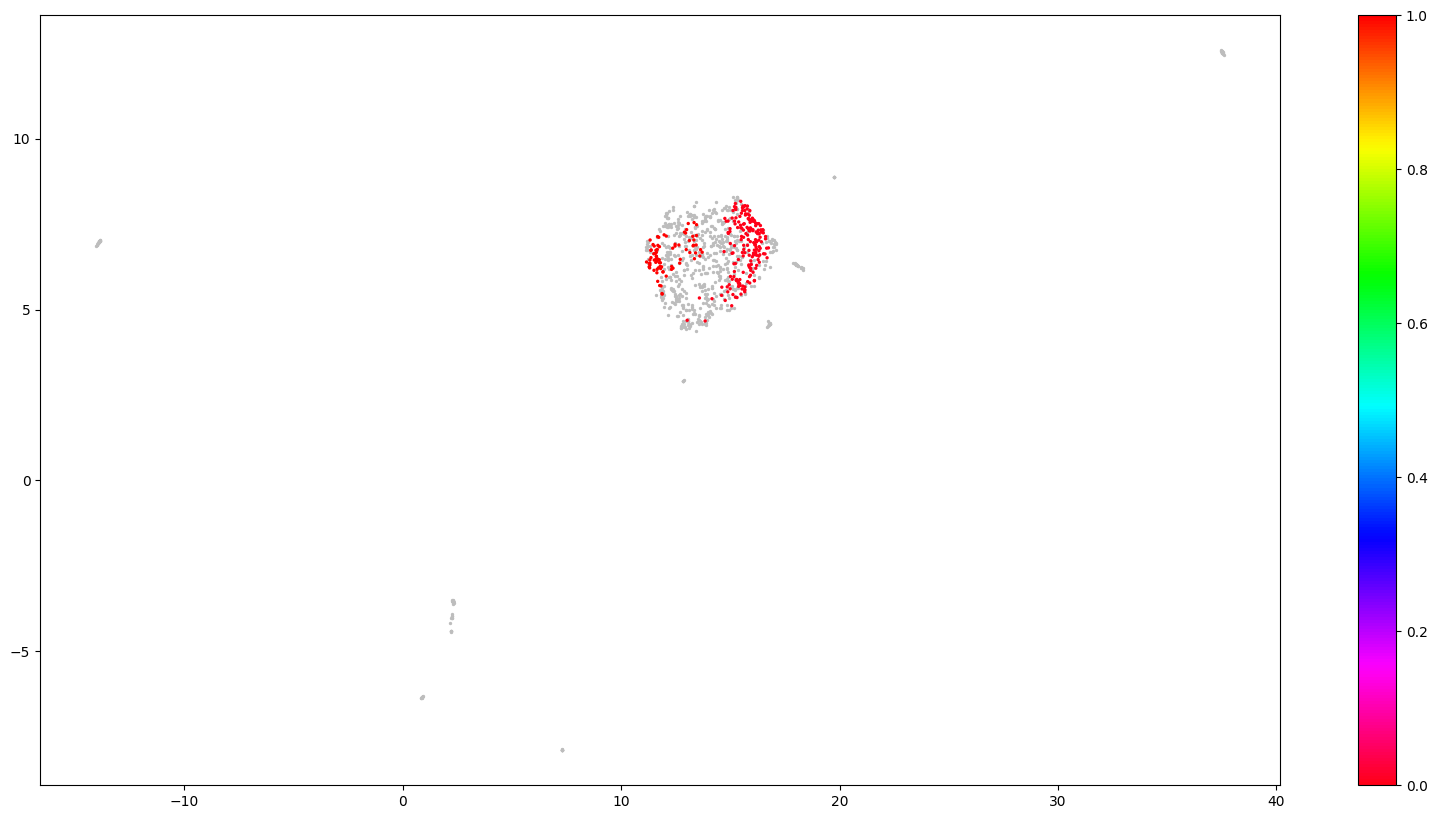

In [15]:
# From Grootendorst

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=2)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
plt.colorbar()

<h3>Topic creation</h3>
<p>First, try using Grootendorst's code:</p>

In [36]:
# From Grootendorst's example:
docs_df = pd.DataFrame(training_set, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(training_set))

In [38]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=50)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
7,6,8725
1,0,304
0,-1,239
4,3,230
2,1,185
5,4,137
3,2,98
6,5,82


In [44]:
for key in top_n_words.keys():
    print(top_n_words[key][:20])

[('styleref', 0.23514764585926817), ('mergeformat', 0.23514764585926817), ('kantrubrik', 0.23514764585926817), ('frågestund', 0.1186711690167784), ('partiledardebatt', 0.07599902750197525), ('fattades', 0.06645509557271745), ('beslut', 0.06371226359131957), ('internationellt', 0.04734328524297025), ('återrapportering', 0.04559743533752785), ('rådets', 0.04343608078889605), ('europeiska', 0.04197502069000336), ('fråga', 0.040863274093309886), ('and', 0.04027344050476562), ('möte', 0.04023263537756947), ('bistånd', 0.04006618076865076), ('oktober', 0.036248233948754975), ('sexuellt', 0.0349135286428213), ('naturvård', 0.03479287588957003), ('medlemskap', 0.0339945580746468), ('övergrepp', 0.033839392755029084)]
[('utrikespolitisk', 1.0195446977898266), ('debatt', 0.6858476544719176), ('mergeformat', 0.5522051980824051), ('styleref', 0.5522051980824051), ('kantrubrik', 0.5522051980824051), ('cirkulära', 0.10728259998705215), ('textilier', 0.10591234208170366), ('strategi', 0.0861837913967